In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [5]:
# Import and process banknotes data
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

banknotes = pd.read_csv('banknotes.csv')
banknotes_predictors = banknotes.drop('class', axis=1).values
banknotes_classes = to_categorical(banknotes['class'].values)

banknotes_predictors_train, banknotes_predictors_test, banknotes_classes_train, banknotes_classes_test = \
  train_test_split(banknotes_predictors, banknotes_classes, test_size=.3)

In [14]:
# Load banknotes classifier from disk
from tensorflow.keras.models import load_model

model = load_model('banknotes_classifier.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Predict on the test set using the usual API
predictions = model.predict(banknotes_predictors_test)

In [20]:
# Predict on the test set by manipulating the model's layers
# Input and output tensors from the 1st layer of the model
inp, out = model.layers[0].input, model.layers[0].output

# Define a function from inputs to outputs
# The connection from inputs to outputs is known to Keras
# This information is held as global state, and is used to power the functional api
inp_to_out = tf.keras.backend.function([inp], [out])

# Calculate the results of passing bankbanknotes_predictors_test through the 1st layer
output = inp_to_out([banknotes_predictors_test])[0]

In [46]:
# Compare neural network predictions with layer predictions
# As the network has a single layer, outputs should be equal
# We observe slight differences due to floating point noise
pd.options.display.float_format = '{:e}'.format
comparison = pd.DataFrame({
  'predictions': predictions.flatten(),
  'output': output.flatten(),
  'comparison': (predictions == output).flatten(),
})

# Briefly inspect the data
print(comparison.head(), '\n\n')


# Make a precise numerical comparison of the outoput arrays
# Take noise into consideration
def compare(array1, array2, decimals=1):
  return (np.round(array1, decimals=decimals) == np.round(array2, decimals=decimals)).all()

print(
  compare(predictions, output, decimals=5),
  compare(predictions, output, decimals=6)
)

   predictions       output  comparison
0 9.731628e-01 9.731628e-01        True
1 2.719322e-02 2.719322e-02        True
2 2.472311e-03 2.472281e-03       False
3 6.393920e-01 6.393920e-01        True
4 1.047999e-02 1.047993e-02       False 


True False


In [59]:
# Extract inner layer using the functional api
from tensorflow.keras.models import Model
functional_model = Model(inputs=model.input, outputs=model.layers[-1].output)

functional_predictions = functional_model.predict(banknotes_predictors_test)

# Compare functional predictions with standard predictions
# We don't observe floating point noise in this case
# Such results suggest this method of extracting layers is superior
for i in range(10):
  print(
    compare(predictions, functional_predictions, decimals=i)
  )

True
True
True
True
True
True
True
True
True
True


In [68]:
# Parcel irrigation data
# Three parcels, ¿do we have to irrigate or not?
irrigation = pd.read_csv('irrigation_machine.csv').drop('Unnamed: 0', axis=1)
parcel_columns = ['parcel_0', 'parcel_1', 'parcel_2']
parcels = irrigation[parcel_columns].values
sensors = irrigation.drop(parcel_columns, axis=1).values

from sklearn.model_selection import train_test_split
sensors_train, sensors_test, parcels_train, parcels_test = \
  train_test_split(sensors, parcels, test_size=0.3)

In [63]:
from tensorflow.keras.models import load_model

irrigation_model = load_model('best_model.hdf5')
irrigation_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               2688      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [87]:
irrigation_model.layers

In [102]:
[type(layer) for layer in irrigation_model.layers]

[keras.layers.core.Dense,
 keras.layers.core.Dropout,
 keras.layers.core.Dense,
 keras.layers.core.Dropout,
 keras.layers.core.Dense,
 keras.layers.core.Dropout,
 keras.layers.core.Dense,
 keras.layers.core.Dropout,
 keras.layers.core.Dense,
 keras.layers.core.Dropout,
 keras.layers.core.Dense]

In [115]:
dense_layers = [layer for layer in irrigation_model.layers if type(layer) == Dense]

In [117]:
from tensorflow.keras.models import Model

prediction_steps = [sensors_train]
for dense_layer in dense_layers:
  inputs, outputs = irrigation_model.input, dense_layer.output
  intermediate_model = Model(inputs=inputs, outputs=outputs)
  intermediate_predictions = intermediate_model.predict(sensors_train)
  prediction_steps.append(intermediate_predictions)

In [124]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

embedder = PCA(n_components=2)

embeddings = [embedder.fit_transform(prediction_step) for prediction_step in prediction_steps]

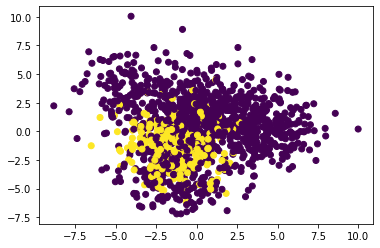

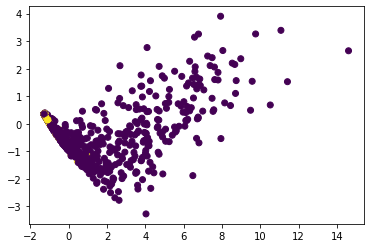

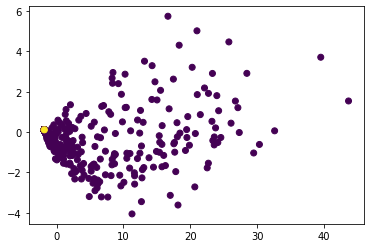

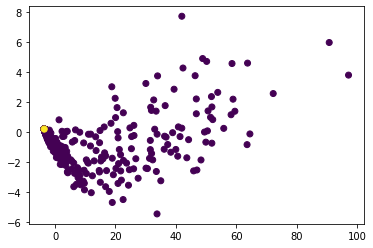

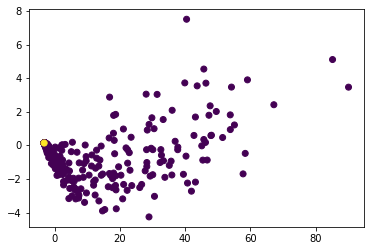

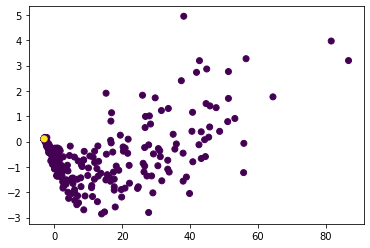

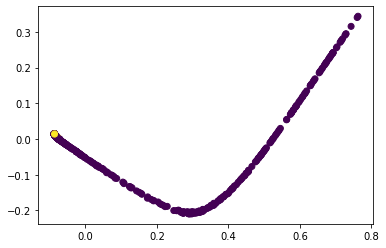

In [125]:
for embedding in embeddings:
  plt.figure()
  plt.scatter(x=embedding[:,0], y=embedding[:,1], c=parcels_train[:,2])
  plt.plot()